In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../../..')))

In [2]:
import numpy as np
factorial = np.math.factorial
import matplotlib.pyplot as plt
from tqdm import tqdm

# custom modules
import Surrogates.PolynomialChaosExpansion as PCE

from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

from GSI_PCE import GSI_PCE

# Model Evaluations

$\sigma(t, \dot{\varepsilon} ; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin})$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



# Monotonic Loading

In [3]:
number_of_realizations = 2500
t_min = 0
t_max = 2
delta_t = 1e-3 # time step
n_t = int((t_max-t_min)/delta_t)

max_strain = 5e-2
time_to_max_strain = 1

model = ChabocheModel('1D', 'monotonic', max_strain, time_to_max_strain)

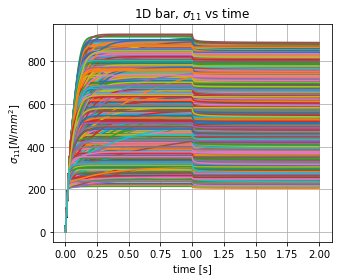

In [4]:
# store samples of parameters
# each row contains 1 set of parameters
SampleSpace = chaboche_samples(number_of_realizations) # [number_of_realizations, 8] matrix

# For monotonic loading
# set b_kin and Q_kin to 0
SampleSpace[:, 6] = 0 # set Q_kin to 0
SampleSpace[:, 7] = 0 # set b_kin to 0

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

# Variance vs time

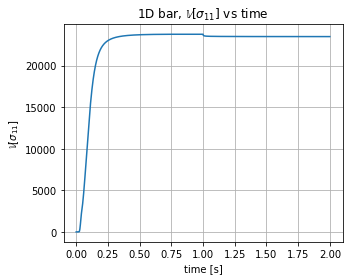

In [5]:
T = np.linspace(t_min, t_max, n_t+1)

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, np.var(func_evaluations, axis=1))

ax.set_title(r'1D bar, $\mathbb{V}[\sigma_{11}]$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\mathbb{V}[\sigma_{11}]$')
ax.grid()

# GSI with PCE

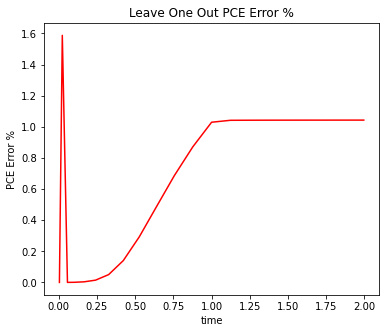

In [8]:
total_polynomial_degree = 6
total_quad_points = 25

# For monotonic loading,
# set Q_kin and b_kin to 0
number_of_random_variables = 6
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

Chaboche_PCE_Sobol = GSI_PCE(t_min, t_max, delta_t, total_quad_points, SampleSpace[:, :6], func_evaluations, total_polynomial_degree, 
                            polynomial_classes_of_random_variables, chaboche_uniform_isoprob_monotonic_transform)

G_first, G_tot = Chaboche_PCE_Sobol.generalised_Sobol(PCE_error = True)

Total order effects: [0.00143309 0.14191105 0.81204125 0.05592946 0.00357398 0.00475326]
First order effects: [4.21203096e-05 1.40348619e-01 7.97433540e-01 4.09541669e-02
 1.64979102e-03 2.90902343e-03]
Interaction effects: [0.00139097 0.00156243 0.01460771 0.0149753  0.00192419 0.00184424]


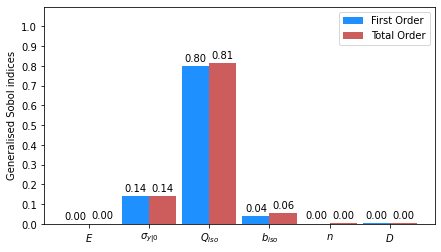

In [7]:
Chaboche_PCE_Sobol.plot_GSI(G_first, G_tot)

# GSI Evolution using PCE

In [34]:
total_polynomial_degree = 5
total_quad_points = 25

# For monotonic loading,
# set Q_kin and b_kin to 0
number_of_random_variables = 6
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

# time points at which GSI must to computed
n = 501
time_points = np.linspace(0, 2, n) 
time_points[0] = 3e-3 # avoid starting at 0, 3e-3 since a cubic interpolation is used to iterpolate

GSI_indices_first = np.zeros((number_of_random_variables, n)) # store first order Sobol indices
GSI_indices_total = np.zeros((number_of_random_variables, n)) # store total order Sobol indices

number_of_PCE_terms = int (factorial(number_of_random_variables+total_polynomial_degree) / ( factorial(number_of_random_variables) * factorial(total_polynomial_degree) ))

print(f"Number of PCE terms: {number_of_PCE_terms}")
print(f"Number of evaluations needed (empirical estimate): {(number_of_random_variables - 1)*number_of_PCE_terms}") # (M-1)*P [Sudret]
print(f"Number of function evaluations: {func_evaluations.shape[1]}") 

for k in tqdm(range(n), ncols = 100):

    t_i = time_points[k]

    i = 1 + int(t_i/delta_t) 

    func_evaluations_upto_t_i = func_evaluations[:i, :]

    Chaboche_PCE_Sobol = GSI_PCE(t_min, t_i, delta_t, total_quad_points, SampleSpace[:, :6], func_evaluations_upto_t_i, total_polynomial_degree, 
                                polynomial_classes_of_random_variables, chaboche_uniform_isoprob_monotonic_transform)

    G_first, G_tot = Chaboche_PCE_Sobol.generalised_Sobol(PCE_error = False)

    GSI_indices_first[:, k] = G_first
    GSI_indices_total[:, k] = G_tot

  0%|                                                                       | 0/501 [00:00<?, ?it/s]

Number of PCE terms: 462
Number of evaluations needed (empirical estimate): 2310
Number of function evaluations: 2500


100%|█████████████████████████████████████████████████████████████| 501/501 [42:38<00:00,  5.11s/it]


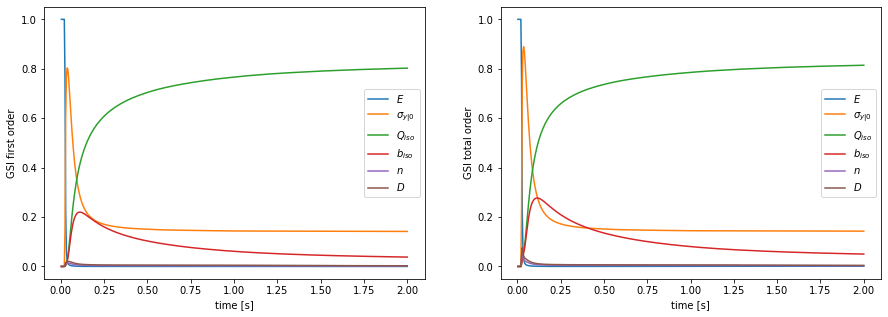

In [37]:
fig, ax = plt.subplots(1, 2,figsize=(15,5))

params = [  r'$E$',
            r'$\sigma_{y|0}$',
            r'$Q_{iso}$',
            r'$b_{iso}$',
            r'$n$',
            r'$D$']

ax[0].plot(time_points, GSI_indices_first[0,:].T, label= params[0])
ax[0].plot(time_points, GSI_indices_first[1,:].T, label= params[1])
ax[0].plot(time_points, GSI_indices_first[2,:].T, label= params[2])
ax[0].plot(time_points, GSI_indices_first[3,:].T, label= params[3])
ax[0].plot(time_points, GSI_indices_first[4,:].T, label= params[4])
ax[0].plot(time_points, GSI_indices_first[5,:].T, label= params[5])

ax[0].set_xlabel('time [s]')
ax[0].set_ylabel('GSI first order')

ax[0].legend()

ax[1].plot(time_points, GSI_indices_total[0,:].T, label= params[0])
ax[1].plot(time_points, GSI_indices_total[1,:].T, label= params[1])
ax[1].plot(time_points, GSI_indices_total[2,:].T, label= params[2])
ax[1].plot(time_points, GSI_indices_total[3,:].T, label= params[3])
ax[1].plot(time_points, GSI_indices_total[4,:].T, label= params[4])
ax[1].plot(time_points, GSI_indices_total[5,:].T, label= params[5])

ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('GSI total order')

ax[1].legend()

plt.show()